Taken from:-

https://www.analyticsvidhya.com/blog/2020/07/how-to-train-an-image-classification-model-in-pytorch-and-tensorflow/

Import libraries

In [36]:
# importing the libraries
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

Check version of PyTorch

In [37]:
# version of pytorch
print(torch.__version__)

1.8.1+cu101


Transform images

In [38]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

Load datasets

In [39]:
# defining the training and testing set
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

In [40]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Summary

In [41]:
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Visualise training images

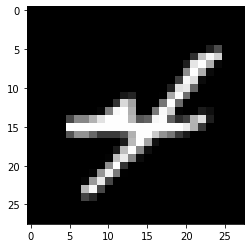

In [42]:
# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

Visualise test image

In [43]:
# shape of validation data
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Define CNN

In [44]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

Define optimiser and loss function

In [45]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


Train model

In [46]:
epoch = 20

for i in range(epoch):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.16985858895970798
Epoch 2 - Training loss: 0.09096984497841391
Epoch 3 - Training loss: 0.07982556076572914
Epoch 4 - Training loss: 0.07547396145411518
Epoch 5 - Training loss: 0.07228435415413174
Epoch 6 - Training loss: 0.06849199841727319
Epoch 7 - Training loss: 0.06845545880213531
Epoch 8 - Training loss: 0.06457412474689933
Epoch 9 - Training loss: 0.0641959893035897
Epoch 10 - Training loss: 0.06279396051382109
Epoch 11 - Training loss: 0.06123507746730123
Epoch 12 - Training loss: 0.06041015145581847
Epoch 13 - Training loss: 0.05958586439802083
Epoch 14 - Training loss: 0.058591273439395776
Epoch 15 - Training loss: 0.05785466958460873
Epoch 16 - Training loss: 0.05662388809751084
Epoch 17 - Training loss: 0.05575880746462388
Epoch 18 - Training loss: 0.056214525687646295
Epoch 19 - Training loss: 0.05502187495424188
Epoch 20 - Training loss: 0.05450338417548624


Check performance on test set

In [47]:
# getting predictions on test set and measuring the performance

prediction  = []
label = []

correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    prediction.append(pred_label)
    label.append(true_label)

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9197


In [48]:
len(prediction)

10000

In [56]:
len(label)

10000

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(label, prediction)

array([[ 965,    0,    4,    0,    0,    2,    7,    1,    1,    0],
       [   0,  610,   22,   74,    5,    2,    8,    2,  397,   15],
       [   1,    0, 1015,    1,    0,    1,    2,    8,    3,    1],
       [   1,    0,    5,  982,    1,    3,    0,    6,    8,    4],
       [   0,    0,    4,    0,  919,    0,    5,    4,    3,   47],
       [   4,    0,    0,    9,    1,  836,    7,    1,   22,   12],
       [   2,    1,    2,    0,    6,    1,  943,    0,    3,    0],
       [   0,    1,    9,    2,    0,    0,    0, 1002,    3,   11],
       [   3,    0,    8,    4,    7,    2,    3,    2,  932,   13],
       [   0,    0,    0,    1,    2,    1,    0,    6,    6,  993]])

In [54]:
df = pd.DataFrame({'Actual': label, 'Predicted':prediction})
df

,Actual,Predicted
0,tensor(8),8
1,tensor(4),4
2,tensor(0),0
3,tensor(3),3
4,tensor(3),3
...,...,...
9995,tensor(2),2
9996,tensor(8),8
9997,tensor(4),9
9998,tensor(1),8
